In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [2]:
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

In [3]:
def step1(state: CrashState) -> CrashState:
    print('Step 1 executed')
    return {'step1': 'done', input: state['input']}

def step2(state: CrashState) -> CrashState:
    print('Step 2 execution - sleeping for 30 seconds - to simulate a crash by manual intervention')
    # Simulate a crash
    time.sleep(30)
    return {'step2': 'done'}

def step3(state: CrashState) -> CrashState:
    print('Step 3 executed')
    return {'step3': 'done'}

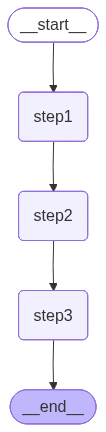

In [4]:
# Build the graph

graph = StateGraph(CrashState)

# add nodes
graph.add_node("step1", step1)
graph.add_node("step2", step2)
graph.add_node("step3", step3)

# add edges
graph.add_edge(START, "step1")
graph.add_edge("step1", "step2")
graph.add_edge("step2", "step3")
graph.add_edge("step3", END)

# checkpointer - save each state to memory
checkpointer = InMemorySaver()

# graph compilation
workflow = graph.compile(checkpointer=checkpointer)
workflow

In [5]:
# Run the graph
inital_state = {'input': 'Hello'}

# setup congfigurable
config = {'configurable': {'thread_id': '1'}}

try:
    state = workflow.invoke(inital_state, config=config)
    print(state)
except Exception as e:
    print(e)
    print('Workflow failed')

Step 1 executed
Step 2 execution - sleeping for 30 seconds - to simulate a crash by manual intervention


KeyboardInterrupt: 

In [6]:
workflow.get_state(config=config)

# we simulated a crash in step 2 manually, we can see in the state has input and step1 but not step2 as it failed
# we can also see step 2 is next to be executed

StateSnapshot(values={'input': 'Hello', 'step1': 'done'}, next=('step2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c3a-69de-8001-6cde97f59c8a'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-16T15:08:25.822041+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c38-663e-8000-2b9403f94531'}}, tasks=(PregelTask(id='612a8992-1843-98b8-0f1d-16d0a9073cdb', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [ ]:
list(workflow.get_state_history(config=config)) # we can see the state history 

[StateSnapshot(values={'input': 'Hello', 'step1': 'done'}, next=('step2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c3a-69de-8001-6cde97f59c8a'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-16T15:08:25.822041+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c38-663e-8000-2b9403f94531'}}, tasks=(PregelTask(id='612a8992-1843-98b8-0f1d-16d0a9073cdb', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'Hello'}, next=('step1',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c38-663e-8000-2b9403f94531'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-16T15:08:25.821123+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c36-6d0

In [8]:
# Now let us resume the workflow - it will resume from step 2
# we need to provide initial state as None and same config as before to resume from step 2

final_state = workflow.invoke(None, config=config)
print(final_state)

Step 2 execution - sleeping for 30 seconds - to simulate a crash by manual intervention
Step 3 executed
{'input': 'Hello', 'step1': 'done', 'step2': 'done', 'step3': 'done'}


In [9]:
# Here we can see the state has input, step1, step2 and step3
workflow.get_state(config=config)

StateSnapshot(values={'input': 'Hello', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe5-2253-65d6-8003-7d759f1651f3'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-11-16T15:10:00.413733+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe5-2252-6384-8002-b89d240b0d21'}}, tasks=(), interrupts=())

In [10]:
list(workflow.get_state_history(config=config)) # full  history of the workflow

[StateSnapshot(values={'input': 'Hello', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe5-2253-65d6-8003-7d759f1651f3'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-11-16T15:10:00.413733+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe5-2252-6384-8002-b89d240b0d21'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'Hello', 'step1': 'done', 'step2': 'done'}, next=('step3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe5-2252-6384-8002-b89d240b0d21'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-16T15:10:00.413256+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c2fe1-9c3a-69de-8001-6cde97f59c8a'}}, tasks=(PregelTask(id='831633e1-2180-4e76-56ee-0e087290d686', name='st